# CNN: VGG-16

### CA4 @ AI Course

*َAmir Faridi*

*610300087*


![](https://i.postimg.cc/qR2ghvVg/VGG-16.png)

In [1]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt

from termcolor import colored
def cprint(text : str, color : str = "yellow") -> None:
    print(colored(text, color))

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1 * 1 * 512, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cprint(f"Device: {device}", "green")

Device: cuda


In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261)),
])

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        return tensor * self.std.view(3, 1, 1) + self.mean.view(3, 1, 1)

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

In [8]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

BATCH_SIZE = 128

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [40000, 10000])

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
classes = initial_trainset.classes

def visualize_samples(loader, classes, num_samples=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    class_samples = {cls: [] for cls in range(len(classes))}
    for img, label in zip(images, labels):
        if len(class_samples[label.item()]) < num_samples:
            class_samples[label.item()].append(img)

    fig, axes = plt.subplots(num_samples, len(classes), figsize=(15, 8))
    for col, cls in enumerate(classes):
        for row in range(num_samples):
            if class_samples[col]:
                img = norminv(class_samples[col][row])
                img = img.permute(1, 2, 0).numpy()
                axes[row, col].imshow(img)
            axes[row, col].axis('off')
            if row == 0:
                axes[row, col].set_title(cls)

    plt.tight_layout()
    plt.show()
# visualize_samples(trainloader, classes)

In [14]:
net = VGG16(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, weight_decay=0.005, momentum=0.9)

def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

epochs = 30
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for e in range(epochs):
    train_loss, train_acc = train_epoch(net, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(net, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    cprint(f"Epoch {e+1}/{epochs}")
    cprint(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    cprint(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%\n")

Epoch 1/30
Train Loss: 1.4978, Train Accuracy: 43.53%
Val Loss: 1.3485, Val Accuracy: 52.78%

Epoch 2/30
Train Loss: 0.9304, Train Accuracy: 67.48%
Val Loss: 1.0720, Val Accuracy: 64.64%

Epoch 3/30
Train Loss: 0.7119, Train Accuracy: 75.69%
Val Loss: 0.8299, Val Accuracy: 71.55%

Epoch 4/30
Train Loss: 0.5645, Train Accuracy: 80.92%
Val Loss: 0.7982, Val Accuracy: 74.42%

Epoch 5/30
Train Loss: 0.4810, Train Accuracy: 84.01%
Val Loss: 0.7123, Val Accuracy: 76.63%

Epoch 6/30
Train Loss: 0.4107, Train Accuracy: 86.41%
Val Loss: 0.7630, Val Accuracy: 75.46%

Epoch 7/30
Train Loss: 0.3448, Train Accuracy: 88.62%
Val Loss: 0.9560, Val Accuracy: 72.77%

Epoch 8/30
Train Loss: 0.3077, Train Accuracy: 89.94%
Val Loss: 0.6247, Val Accuracy: 80.47%

Epoch 9/30
Train Loss: 0.2732, Train Accuracy: 91.07%
Val Loss: 0.7057, Val Accuracy: 78.23%

Epoch 10/30
Train Loss: 0.2350, Train Accuracy: 92.37%
Val Loss: 0.6797, Val Accuracy: 79.59%

Epoch 11/30
Train Loss: 0.2203, Train Accuracy: 92.74%
Val 

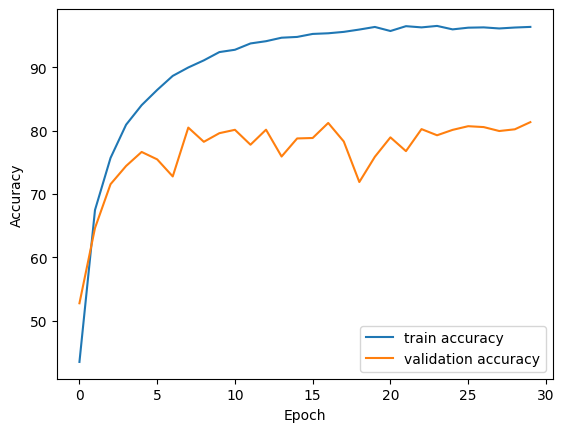

In [15]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
test_loss, test_acc = eval_epoch(net, criterion, testloader)
cprint(f"Test Loss: {test_loss:.4f}", "blue")
cprint(f"Test Accuracy: {test_acc:.2f}%", "magenta")

Test Loss: 0.6738
Test Accuracy: 81.07%


The main use of convolutional layers in CNN models, is to extract features from the input data such as edges.

They kernels in order to focus more on local regions to ensure that the spatial relationships with the data are preserved.

After the feature extraction using the convolutional layers, fully connected layres are used in order to combine the extractions from the convolutional layers to analyze it for a prediction.

With the explanations above, and the main goal of convolutional layers, it is obvious why we don't use fully connected layers instead. Some of the reasons are:

1- The number of parameters would be significantly larger, making the model to require much more train data.

2- As explained above, the locality would be lost if we used fully connected layers. (The reason is that the convolutional layers use kernels)